# Introduction to Computer Vision



## Used Libraries

In [81]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

## Camera Module

The Pin-Hole-Camera Model is a widely used camera model in computer vision. 

In [82]:
class Camera(object):
    """ Class for representing pin-hole cameras. """

    def __init__(self, P):
        """ Initialize P = K[R|t] camera model. """
        
        self.P = P
        self.K = None # calibration matrix
        self.R = None # rotation
        self.t = None # translation
        self.c = None # camera center

    def project(self, X):
        """ Project points in X (4**n array) and normalize coordinates. """

        x = np.dot(self.P, X)
        for i in range(3):
            x[i] /= x[2]

        return x

    def rotation_matrix(a):
        """ Creates a 3D rotation matrix for rotation around the axis of the vector a """

        R = np.eye(4)
        R[:3, :3] = linalg.expm([[0, -a[2], a[1]], [a[2], 0, -a[0]], [-a[1], a[0], 0]])
        return R
    

First we need to load the data from our example. In this example we will use the "Model-House" which is one of the Oxformd multi-view datasets. Then we make the points into homogeneous coordinates and create a **Camera** object, with the projection matrix.

In [83]:
#import camera

# load points
points = np.loadtxt('./Examples/Model_House/house.p3d')
# matrix needs to be transposed becuase it expects the points to be like this:
# X: [[1,3,5,3,4,6,7,4,6,25,7,2,7,4,45,...],
# Y:  [6,-3,6,2,78,2,7,2,4,67,2,6,34,6,...],
# Z:  [2,5,1,545,2,345,6,2,6,2,3,4,6,2,...]
#and not like this:
#   X  Y  Z
# [[3, 6, 2],
#  [2, 6, 2],
#  [5, 2, 7],
#  [9, 0, 1],
#  ...]
# => so we need to change columns and rows
points = points.T
points = np.vstack((points, np.ones(points.shape[1])))
# np.ones(N) returns a array with size N filled with 1s

# setup camera
P = np.hstack((np.eye(3), np.array([[0],[0],[-10]])))
# np.eye(N) creates a identity matrix with dimensions NxN
cam = Camera(P)

Then the points a projected and plotted. Which looks like this:

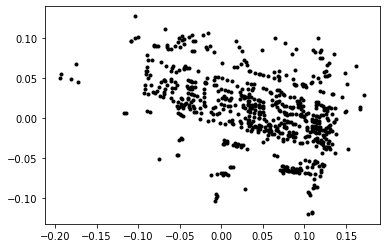

In [84]:
# project the points
x = cam.project(points)

#plot projection
plt.figure()
plt.plot(x[0], x[1], 'k.')
#plt.plot(x[:, 0], x[:, 1], 'k.')
plt.show()

To see the change in projection while moving the camera, we will create the following example:

In [ ]:
# create transformation
r = 0.05 * np.random.rand(3)
rot = Camera.rotation_matrix(r)

# rotate camera and project
plt.figure()
for t in range(20):
    cam.P = np.dot(cam.P, rot)
    x = cam.project(points)
    plt.plot(x[0], x[1], 'k')

plt.show()